In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np

import os
from os import listdir
from os.path import isfile, join
from collections import deque

import PIL
from PIL import Image
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
def norm_img(img):
    img = (img / 127.5) - 1
    return img

def load_images(data_dir, batch_size, image_shape):
    sample_dim = (batch_size,) + image_shape
    sample = np.empty(sample_dim, dtype=np.float32)
    
    sample_imgs_paths = [join(data_dir, f) for f in listdir(data_dir) if 'png' in f]
    sample_imgs_paths = np.random.choice(sample_imgs_paths,batch_size, replace=False)
    for index,img_filename in enumerate(sample_imgs_paths):
        print(img_filename)
        image = Image.open(img_filename)
        image = image.resize(image_shape[:-1])
        image = image.convert('RGB')
        image = np.asarray(image)
        image = norm_img(image)
        sample[index,...] = image
    return sample

In [3]:
# train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
BATCH_SIZE = 5
IMAGE_SHAPE = (64, 64, 3)
OUPUT_DIR = './tf_output/'
train_dataset = load_images('./input_source_word', BATCH_SIZE, IMAGE_SHAPE)

./input_source_word/uni3$B57_MicrosoftJhengHeiRegular.png
./input_source_word/uni3$B43_MicrosoftJhengHeiRegular.png
./input_source_word/uni3$B58_MicrosoftJhengHeiRegular.png
./input_source_word/uni3$B77_MicrosoftJhengHeiRegular.png
./input_source_word/uni3$B66_MicrosoftJhengHeiRegular.png


In [4]:
# train_dataset[0]
for image_batch in train_dataset:
    print(image_batch.shape)
    break

(64, 64, 3)


In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [7]:
def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [8]:
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [9]:
def get_checkpoint(generator_optimizer, discriminator_optimizer, generator, discriminator):
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)
    return checkpoint

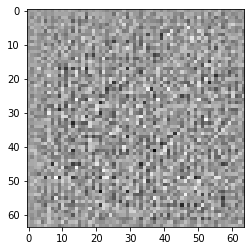

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision, generated_image.shape)

tf.Tensor([[-0.00114424]], shape=(1, 1), dtype=float32) (1, 64, 64, 3)


In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, noise_dim):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return [gen_loss, disc_loss]

In [14]:
def generate_and_save_images(ouput_dir, model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
    plt.imshow(predictions[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

    plt.savefig('{}image_at_epoch_{:04d}.png'.format(ouput_dir, epoch))
    plt.show()

In [15]:
def train(images, ouput_dir):
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = get_checkpoint(generator_optimizer, discriminator_optimizer, generator, discriminator)
    EPOCHS = 8500
    noise_dim = 100
    num_examples_to_generate = 5
    disc_loss_array = deque([0], maxlen=20)
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    
    for epoch in range(EPOCHS):
        start = time.time()

        gen_loss, disc_loss = train_step(images, noise_dim)
        disc_loss_array.append(disc_loss)
    
        if epoch % 20 == 0:
            display.clear_output(wait=True)
            generate_and_save_images(ouput_dir,
                                     generator,
                                     epoch + 1,
                                     seed)
            diff = tf.math.subtract(max(disc_loss_array), min(disc_loss_array))
            print(epoch, diff)
            if len(disc_loss_array) >= 5 and diff < 0.000001:
                return

            
        if (epoch + 1) % 150 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(ouput_dir,
                             generator,
                             EPOCHS,
                             seed)

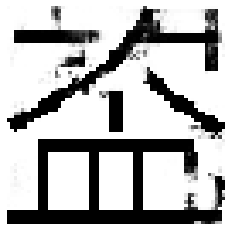

In [16]:
train(train_dataset, OUPUT_DIR)

In [17]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))